In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./src")

from utils import sample_Queue
from plot_functions import SeabornFig2Grid, plot_gauss_4d, plot_posterior_marginals_mmd_vs_mabc
import NPL
import models
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.gridspec as gridspec
import time
import matplotlib.pyplot as plt
from credible_interval import joint_hpd_region
import jax
device = jax.devices("cpu")[0]

2024-05-13 07:12:00.789170: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-05-13 07:12:00.789918: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-05-13 07:12:00.789943: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/home/zsu/vol_test_wcl3/MMD/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.e

In [2]:
# Before running: 
# 1) Set paths 
# 2) Indicate whether you want a fresh dataset or to load existing one 
# 3) experiments are run for multiple runs - index which run you want plots for

# Paths
data_path = "./data/queueing_model/"
results_path = "./results/queueing_model/"
plots_path = "./plots/queueing_model/"

# Set to True to generate and save fresh datasets or False to load saved datasets
sample_data_bool = True

# Index which run you want to plot results for
r = 0  

In [3]:
# check if the GPU is online
import jax
print(jax.__version__)
print(jax.devices())

0.3.0
[GpuDevice(id=0, process_index=0), GpuDevice(id=1, process_index=0)]


In [5]:
# Set model 
model_name = 'queue' 
n = 2000 # number of samples from the target system, m in the paper
theta_star = np.array([1, 1])
m = 500 # number of samples, n in the paper
p = 2   # number of unknown parameters
B = 300 # number of bootstrap iterations 
model = models.QueueModel(m)
R = 2 # number of independent runs
alpha = 0.05 # significance level

In [6]:
import os

# Create the directory if it doesn't exist
if not os.path.exists(data_path):
    os.makedirs(data_path)

if sample_data_bool:
    for j in range(R):
        X = sample_Queue(theta_star, n, constant_seed=j)
        file_path = os.path.join(data_path, f'run_{j}')
        np.savetxt(file_path, X)

In [7]:
# Load data
datasets = np.zeros((R,n))
for j in range(R):
    X = np.loadtxt(data_path+'run_{}'.format(j))
    datasets[j,:] = X
times = []

In [8]:
# Obtain and save results 
if not os.path.exists(results_path):
    os.makedirs(results_path)
else:
    if not os.path.exists("./results/queueing_model/NPL_MMD/"):
        os.makedirs("./results/queueing_model/NPL_MMD/")
if not os.path.exists(plots_path):
    os.makedirs(plots_path)

l = -1 # bandwidth picked with median heuristic
summary_stats = np.zeros((R, p, 4)) # collect mean, median, mode, st.dev for each bootstrap sample
for j in range(R):
    print("-----Run ", j)
    X =datasets[j,:].reshape((n,1))
    npl = NPL.npl(X,B,m,p,l, model = model, model_name = model_name)
    t0 = time.time()
    npl.draw_samples()
    t1 = time.time()
    total = t1-t0
    times.append(total)
    print(total)
    sample = npl.sample
    summary_stats[j,:,0] = np.mean(sample, axis=0)
    summary_stats[j,:,1] = np.std(sample, axis=0)
    summary_stats[j,:,2] = np.median(sample, axis=0)
    summary_stats[j,:,3] = stats.mode(sample, axis=0)[0]
    np.savetxt(results_path+'NPL_MMD/thetas_mmd_run_{}.txt'.format(j), sample)

-----Run  0
130.10255360603333
-----Run  1
129.39765548706055


In [9]:
np.save(os.path.join(results_path, 'NPL_MMD', 'summary_stats.npy'), summary_stats)
np.savetxt(results_path+'NPL_MMD/cpu_times.txt', times)  


# Calculate joint HPD region
hpd_coverage = 0
for j in range(R):
    sample = np.loadtxt(results_path + 'NPL_MMD/thetas_mmd_run_{}.txt'.format(j))
    hpd_region = joint_hpd_region(sample.T, alpha)
    
    if isinstance(hpd_region, list):
        # If the HPD region is disjoint, check if theta_star is in any of the subregions
        hpd_coverage += np.any([np.all(subregion <= theta_star, axis=1) & np.all(theta_star <= subregion, axis=1) for subregion in hpd_region])
    else:
        # If the HPD region is contiguous, check if theta_star is in the region
        hpd_coverage += np.all(hpd_region <= theta_star, axis=1) & np.all(theta_star <= hpd_region, axis=1)

hpd_coverage /= R
hpd_coverage = np.mean(np.all(hpd_region <= theta_star, axis=1) & np.all(theta_star <= hpd_region, axis=1))

# Print the estimated coverages
print("Joint HPD Coverage:", hpd_coverage)

# Create the directories if they don't exist
os.makedirs(results_path, exist_ok=True)

# Save the estimated coverages to text files
with open(os.path.join(results_path, 'HPD_coverage.txt'), 'w') as f:
    f.write(f"Joint HPD Coverage: {hpd_coverage}\n")

LinAlgError: singular matrix

In [34]:
# Reshape results
r = 2
thetas_mmd = np.zeros((p,B))
for j in range(p):
    sample = np.loadtxt(results_path+'NPL_MMD/thetas_mmd_run_{}.txt'.format(r))
    if p>1:
        thetas_mmd[j,:] = sample[:,j]
    else:
        thetas_mmd[j,:] = sample

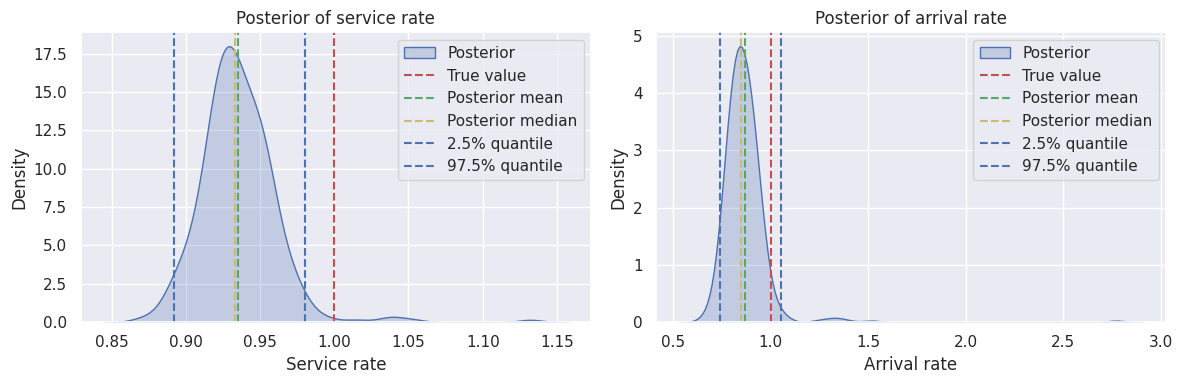

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming thetas_mmd is a 2D array with shape (num_samples, 2)
service_rate = thetas_mmd[0, :]
arrival_rate = thetas_mmd[1, :]

# True parameter values
true_service_rate = 1
true_arrival_rate = 1

# Calculate posterior statistics
service_rate_mean = np.mean(service_rate)
service_rate_median = np.median(service_rate)
service_rate_025 = np.quantile(service_rate, 0.025)
service_rate_975 = np.quantile(service_rate, 0.975)

arrival_rate_mean = np.mean(arrival_rate)
arrival_rate_median = np.median(arrival_rate)
arrival_rate_025 = np.quantile(arrival_rate, 0.025)
arrival_rate_975 = np.quantile(arrival_rate, 0.975)

# Create a figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the density plot for service rate
sns.kdeplot(service_rate, shade=True, ax=ax1, label='Posterior')
ax1.axvline(true_service_rate, color='r', linestyle='--', label='True value')
ax1.axvline(service_rate_mean, color='g', linestyle='--', label='Posterior mean')
ax1.axvline(service_rate_median, color='y', linestyle='--', label='Posterior median')
ax1.axvline(service_rate_025, color='b', linestyle='--', label='2.5% quantile')
ax1.axvline(service_rate_975, color='b', linestyle='--', label='97.5% quantile')
ax1.set_title('Posterior of service rate')
ax1.set_xlabel('Service rate')
ax1.legend()

# Plot the density plot for arrival rate
sns.kdeplot(arrival_rate, shade=True, ax=ax2, label='Posterior')
ax2.axvline(true_arrival_rate, color='r', linestyle='--', label='True value')
ax2.axvline(arrival_rate_mean, color='g', linestyle='--', label='Posterior mean')
ax2.axvline(arrival_rate_median, color='y', linestyle='--', label='Posterior median')
ax2.axvline(arrival_rate_025, color='b', linestyle='--', label='2.5% quantile')
ax2.axvline(arrival_rate_975, color='b', linestyle='--', label='97.5% quantile')
ax2.set_title('Posterior of arrival rate')
ax2.set_xlabel('Arrival rate')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [22]:
 thetas_mmd

array([[0.84680209, 0.85863394, 0.87850905, 0.84565786, 0.83819655,
        1.21394643, 0.84270813, 0.81138805, 0.83915701, 0.85863367,
        0.84342597, 0.90218397, 0.86608944, 0.79152244, 0.93650369,
        0.86858313, 0.8543212 , 0.89188366, 0.82273229, 0.84895813,
        0.82473061, 1.21440142, 0.84834409, 0.81070465, 0.80297967,
        0.83758489, 0.82811949, 1.19881747, 0.85315541, 0.86239772,
        0.90225507, 1.20674715, 0.84972435, 0.8215464 , 0.77889042,
        0.88995605, 0.84439891, 0.84101684, 0.83647428, 0.847965  ,
        0.80958149, 0.84675041, 0.8272267 , 0.81529558, 0.84320685,
        0.82917924, 0.81591756, 0.79361935, 0.78914636, 0.8114207 ,
        0.87923526, 0.84117443, 0.85440313, 0.83414156, 1.20773076,
        0.82857165, 0.80992482, 0.87307902, 0.84069663, 0.85985761,
        0.83160787, 0.81664169, 0.88476753, 0.86436964, 0.86635029,
        0.82955779, 0.80253913, 0.80190057, 0.89269143, 1.19235412,
        0.79416686, 0.88163836, 0.8449507 , 0.90

In [23]:
thetas_mmd[0, :]

array([0.84680209, 0.85863394, 0.87850905, 0.84565786, 0.83819655,
       1.21394643, 0.84270813, 0.81138805, 0.83915701, 0.85863367,
       0.84342597, 0.90218397, 0.86608944, 0.79152244, 0.93650369,
       0.86858313, 0.8543212 , 0.89188366, 0.82273229, 0.84895813,
       0.82473061, 1.21440142, 0.84834409, 0.81070465, 0.80297967,
       0.83758489, 0.82811949, 1.19881747, 0.85315541, 0.86239772,
       0.90225507, 1.20674715, 0.84972435, 0.8215464 , 0.77889042,
       0.88995605, 0.84439891, 0.84101684, 0.83647428, 0.847965  ,
       0.80958149, 0.84675041, 0.8272267 , 0.81529558, 0.84320685,
       0.82917924, 0.81591756, 0.79361935, 0.78914636, 0.8114207 ,
       0.87923526, 0.84117443, 0.85440313, 0.83414156, 1.20773076,
       0.82857165, 0.80992482, 0.87307902, 0.84069663, 0.85985761,
       0.83160787, 0.81664169, 0.88476753, 0.86436964, 0.86635029,
       0.82955779, 0.80253913, 0.80190057, 0.89269143, 1.19235412,
       0.79416686, 0.88163836, 0.8449507 , 0.90298632, 0.81863

In [29]:
np.size(thetas_mmd[0, 1])

1